In [2]:
import os
import sys

In [3]:
sys.path.append('../lib')

In [4]:
import cov_independence_test
import hsic_independence_test
import gen_processes

In [5]:
from importlib import reload

In [6]:
reload(cov_independence_test);
reload(hsic_independence_test);
reload(gen_processes);

In [7]:
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.tsa.ar_model as ar
import torch
torch.set_default_dtype(torch.double)
import sigkernel

In [8]:
import scipy.stats as stats

In [9]:
from tqdm import tqdm

In [10]:
from itertools import product

In [11]:
import matplotlib.pyplot as plt

In [18]:
N_TIMESTEPS = 6000
SIG_KERNEL_SAMPLES_NO = 60
M_RUNS = 60

In [19]:
assert N_TIMESTEPS % SIG_KERNEL_SAMPLES_NO == 0, 'Cannot reshape such array properly'

In [12]:
import pickle

In [3]:
with open('./cov_results.pickle', 'rb') as f:
    cov_results = pickle.load(f)
with open('./hsic_results.pickle', 'rb') as f:
    hsic_results = pickle.load(f)

In [16]:
import pprint
pp = pprint.PrettyPrinter(indent = 4)

In [6]:
#pp.pprint(cov_results)
pp.pprint(hsic_results)

{   0: [   (   tensor([7.2893e-06, 7.9934e-06, 8.3427e-06, 8.6131e-06, 8.8198e-06, 9.4682e-06,
        9.6899e-06, 9.9224e-06, 1.0120e-05, 1.0141e-05, 1.0537e-05, 1.1469e-05,
        1.1618e-05, 1.1697e-05, 1.2314e-05, 1.2553e-05, 1.3001e-05, 1.3594e-05,
        1.4065e-05, 1.4235e-05, 1.5198e-05, 1.5658e-05, 1.7888e-05, 1.8789e-05,
        1.9028e-05, 1.9573e-05, 1.9926e-05, 2.0835e-05, 2.0922e-05, 2.3006e-05,
        2.5411e-05, 2.5454e-05, 2.5967e-05, 2.6251e-05, 2.6574e-05, 2.6840e-05,
        2.6862e-05, 2.7273e-05, 2.7876e-05, 2.8089e-05, 2.8471e-05, 3.0507e-05,
        3.2739e-05, 3.4994e-05, 3.5884e-05, 3.8678e-05, 4.0778e-05, 4.4752e-05,
        4.4857e-05, 5.4659e-05], dtype=torch.float64),
               1.6985554041282214e-05,
               0.56),
           (   tensor([1.1112e-05, 1.3107e-05, 1.4780e-05, 1.5758e-05, 1.6108e-05, 1.7813e-05,
        1.8020e-05, 2.0890e-05, 2.2271e-05, 2.3839e-05, 2.4037e-05, 2.4807e-05,
        2.6944e-05, 2.7009e-05, 2.9170e-05, 3.0769e-05

In [23]:
null_approx = None
for cov in hsic_results.keys():
    for experiment in hsic_results[cov]:
        if null_approx is None:
            null_approx = experiment[0]
        else:
            null_approx = torch.cat((null_approx, experiment[0]), 0)    

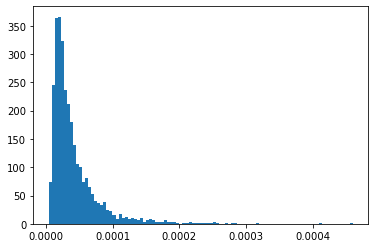

In [27]:
null_sampling_approx = null_approx.numpy()
plt.hist(null_sampling_approx, bins = 100);

In [45]:
null = stats.gamma(*stats.gamma.fit(null_sampling_approx))

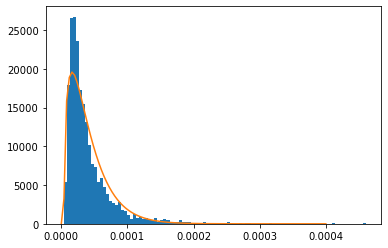

In [48]:
x = np.linspace(0, 4e-4, 100)
bins = plt.hist(null_sampling_approx, bins = 100, density = True);
plt.plot(x, null.pdf(x))

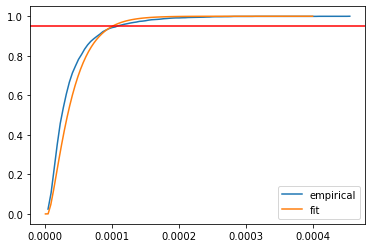

In [65]:
x = np.linspace(0, 4e-4, 100)
plt.plot(bins[1][:100], (np.diff(bins[1])*bins[0]).cumsum(), label = 'empirical')
plt.plot(x, null.cdf(x), label = 'fit')
plt.axhline(0.95, color = 'red')
plt.legend()

In [30]:
with open('./null_approx_numerical_rbf_s2_div8.pickle', 'rb') as f:
    null_ustat_approx = pickle.load(f)
with open('./hisc_dist_corr_03_60_samples.pickle', 'rb') as f:
    hsic_corr_03_approx = pickle.load(f)

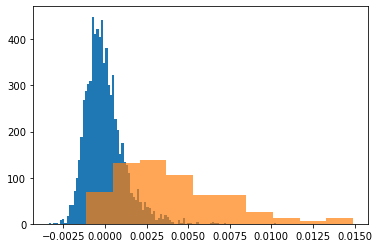

In [31]:
plt.hist(null_ustat_approx.numpy(), bins = 100, density = True);
plt.hist(hsic_corr_03_approx, density = True, alpha = 0.7);